## Лабораторная 1. Иерархический кластерный анализ

Активируем все необходимые нам библиотеки для работы. 

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

#### Загрузка и просмотр данных

Прочитаем данные из файла и сразу посмотрим на них, чтобы понять какие типы данных у нас есть, есть ли пустые значения, выбросы и т.д.

In [3]:
df = pd.read_csv("./Econom_Cities_data.csv", sep=";", decimal = ',', index_col = 'City')
df.head()

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Amsterdam to Zurich
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Work    48 non-null     int64  
 1   Price   48 non-null     float64
 2   Salary  48 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.5+ KB


In [5]:
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


Можно заметить по минимальному значению в Work и Salary, что есть данные, которые можно считать выбросами с отрицательными значениями.
Также данные необходимо нормализовать, так как в изначальном виде они в слишком разных диапазонах.

#### Чистим и нормализуем данные

Посмотрим какие данные с отрицательными значениями и уберем их.

In [6]:
df[(df['Work'] < 0) | (df['Salary'] < 0)]

,Work,Price,Salary
City,,,
Cairo,-9999,37.1,-9999.0
Jakarta,-9999,43.6,-9999.0


In [7]:
df = df.drop(['Cairo', 'Jakarta'])

Теперь нормализуем данные при помощи пакета StandardScaler (приведение к нулевому среднему и единичной дисперсии) из модуля preprocessing библиотеки sklearn (новое значение считается по формуле = (старое значение - среднее)/стандартное отклонение. 

fit - посчитает параметры нормализации, а transform - преобразует данные согласно полученным значениям параметров

In [8]:
scaler = StandardScaler()
scaler.fit(df)
ndf = scaler.transform(df)
ndf = pd.DataFrame(ndf, index=df.index, columns=df.columns)

In [9]:
ndf.head()

,Work,Price,Salary
City,,,
Amsterdam,-0.962166,-0.212712,0.386095
Athens,-0.509827,-0.770489,-0.373488
Bogota,1.577891,-1.522069,-1.145323
Bombay,0.997969,-1.881316,-1.398517
Brussels,-0.996961,0.174896,0.447351


#### Кластеризация 

После того, как привели данные в нормальный вид, можем построить дендрограмму, чтобы посмотреть сколько кластеров можно выделить на этих данных

In [10]:
link = linkage(ndf, 'ward', 'euclidean')

Посмотрим на сколько кластеров предлагает делить сам алгоритм (расстояние вычислиться по формуле h = 0.7*max(link[:,2])). 

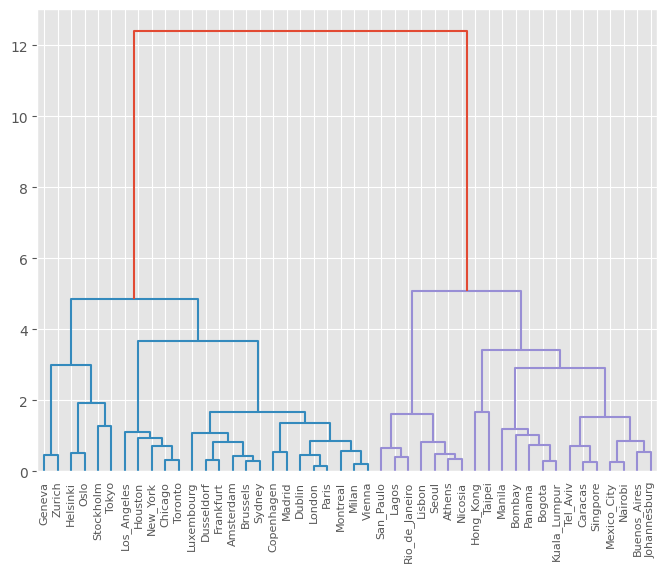

In [11]:
fig = plt.figure(figsize=(8,6))
dn = dendrogram(link, labels= df.index.tolist())
fig

Питон показывает, что тут можно выделить 2 кластера. Посмотрим, как именно он их поделил по данным. 

In [12]:
df['cluster'] = fcluster(link, 2, criterion='maxclust')
df.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
1,1789.240000,84.972000,59.032000
2,1987.857143,52.395238,16.347619


Питон предложил максимально простое деление на бедные и богатые города.

Теперь, чтобы определить оптимальное количество кластеров, воспользуемся графиком локтя, на котором показывается зависимость расстояний между кластерами от шага объединения (обратного). На графике находим момент, начиная с которого расстояние перестанет значительно меняться.

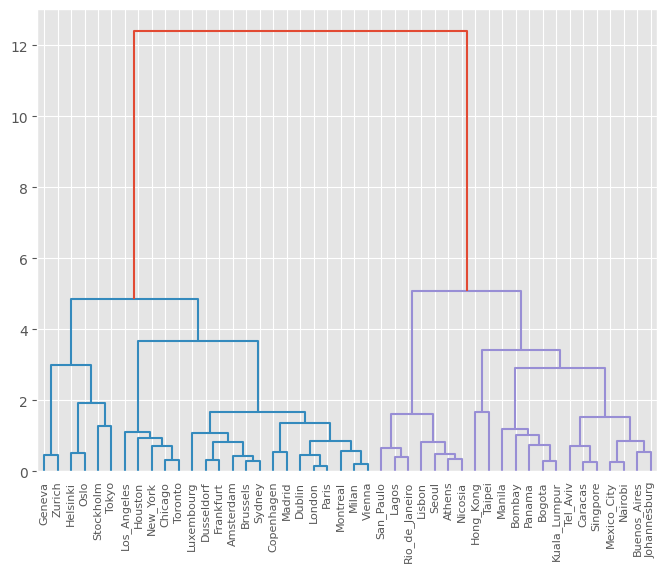

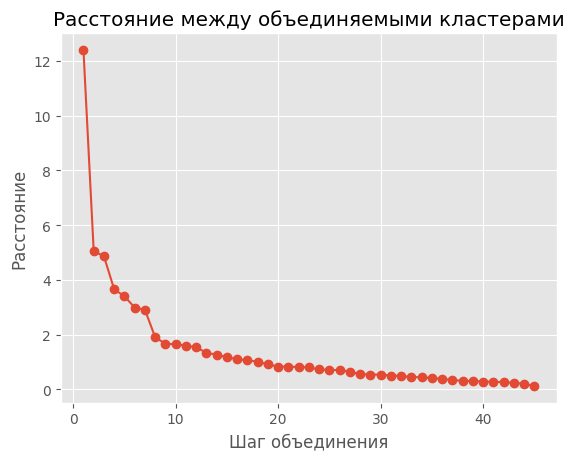

In [13]:
dist = link[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.figure()
plt.plot(idxs, dist_rev, marker='o')
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')
plt.show()

По диаграмме можно заметить, что максимальное деление на кластеры, которое будет содержательным, это деление на 4 кластера. 

Еще раз посмотрим на дендрограмму с уже подкрашенными кластерами и перейдем к интерпретации данного разделения. 

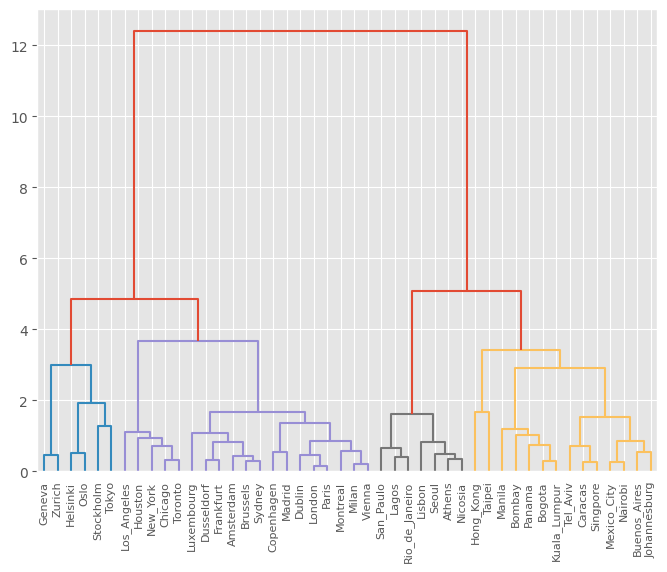

In [14]:
fig = plt.figure(figsize=(8,6))
dn = dendrogram(link, labels= df.index.tolist(),color_threshold=4)
fig

In [16]:
df['cluster'] = fcluster(link, 4, criterion='maxclust')
df.groupby('cluster').mean().round(2)

,Work,Price,Salary
cluster,,,
1,1780.50,108.55,71.30
2,1792.00,77.53,55.16
3,1798.86,50.94,19.21
4,2082.36,53.12,14.91


#### Интрепретация полученных кластеров

Таким образом, можно выделить следующие группы городов: 

1. **Развитые и дорогие.** В таких городах высокие цены, при том, что люди работают меньше других, но получают больше заработной платы. (Женева, Цюрих, Токио и тд.)
2. **Средний класс.** Города, в которых умеренные цены и доходы, стабильный и комфортный уровень жизни. (Нью Йорк, Париж, Сидней и тд.)
3. **Активно развивающиеся.** Более дешёвые города, где люди работают чуть больше, заработки ниже, но расходы также ниже. (Сан-Паоло, Сеул, Рио-де-Жанейро и тд.)
4. **Низкоразвитые.** Страны с дешёвой рабочей силой, где люди работают много, но получают мало, при этом стоимость жизни даже дороже чем в развивающихся. (Манила, Сингапур, Найроби и тд.)